# Imaging and deconvolution demonstration

This script makes a fake data set and then deconvolves it. Finally the full and residual visibility are plotted.

In [3]:
%matplotlib inline

import os
import sys
import multiprocessing

sys.path.append(os.path.join('..', '..'))

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (8.0, 8.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy


from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants as const
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt

from arl.visibility.operations import create_visibility
from arl.skymodel.operations import create_skycomponent
from arl.image.operations import show_image, export_image_to_fits
from arl.image.deconvolution import deconvolve_cube
from arl.image.iterators import raster_iter
from arl.visibility.iterators import vis_timeslice_iter
from arl.util.testing_support import create_named_configuration, create_test_image
from arl.fourier_transforms.ftprocessor import *

import logging

log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))

Construct LOW core configuration

In [4]:
lowcore = create_named_configuration('LOWBD2-CORE')

We create the visibility. This just makes the uvw, time, antenna1, antenna2, weight columns in a table

In [5]:
times = numpy.arange(- numpy.pi / 4.0, + numpy.pi * 1.001 / 4.0, numpy.pi / 16.0)
frequency = numpy.array([1e8])

reffrequency = numpy.max(frequency)
phasecentre = SkyCoord(ra=+15.0 * u.deg, dec=-45.0 * u.deg, frame='icrs', equinox=2000.0)
vt = create_visibility(lowcore, times, frequency, weight=1.0, phasecentre=phasecentre, 
                       spectral_mode='channel', reffrequency=1e8, channelwidth=5e7)

create_visibility: Visibility has 123255 rows, total size 0.298 GB


Plot the synthesized uv coverage, including for MFS

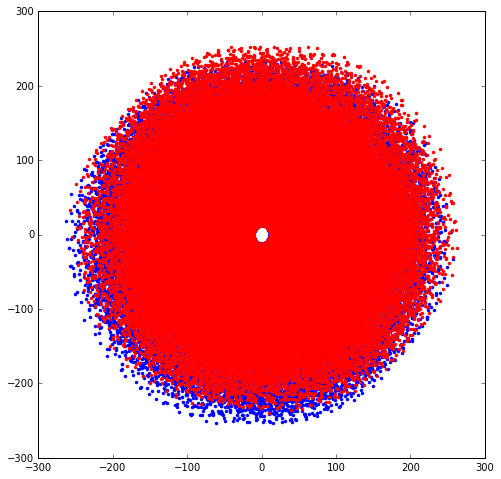

In [6]:
plt.clf()
for f in frequency:
    x=f/const.c
    plt.plot(x*vt.data['uvw'][:,0], x*vt.data['uvw'][:,1], '.', color='b')
    plt.plot(-x*vt.data['uvw'][:,0], -x*vt.data['uvw'][:,1], '.', color='r')

Read the venerable test image, constructing an image

import_image_from_fits: Max, min in /Users/timcornwell/Code/algorithm-reference-library/data/models/M31.MOD = 1.006458, 0.000000
image.operations: created image of shape (256, 256), size 0.006 (GB)
replicate_image: replicating shape (256, 256) to (1, 1, 256, 256)


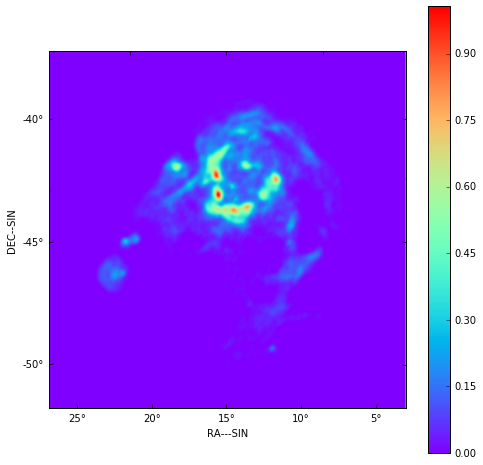

In [7]:
m31image = create_test_image(npol=1, nchan=len(frequency), cellsize=0.001)
nchan, npol, ny, nx = m31image.data.shape
m31image.wcs.wcs.crval[0] = vt.phasecentre.ra.deg
m31image.wcs.wcs.crval[1] = vt.phasecentre.dec.deg
m31image.wcs.wcs.crpix[0] = float(nx // 2)
m31image.wcs.wcs.crpix[1] = float(ny // 2)

fig=show_image(m31image)

predict_2d: predict using 2d transform
shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 14.91905245, -44.94267559)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


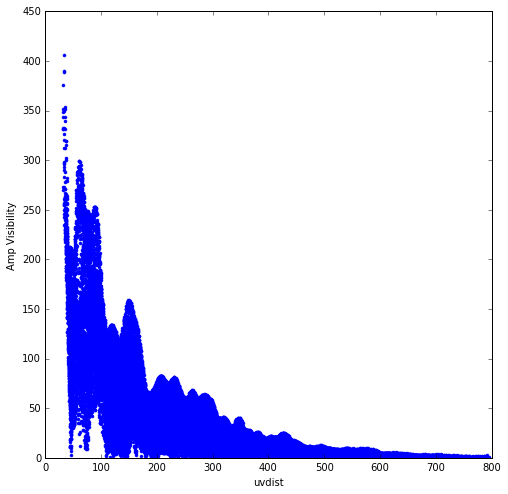

In [8]:
vt = predict_2d(vt, m31image)

# To check that we got the prediction right, plot the amplitude of the visibility.
uvdist=numpy.sqrt(vt.data['uvw'][:,0]**2+vt.data['uvw'][:,1]**2)
plt.clf()
plt.plot(uvdist, numpy.abs(vt.data['vis'][:,0,0]), '.')
plt.xlabel('uvdist')
plt.ylabel('Amp Visibility')
plt.show()

Make the dirty image and point spread function

create_wcs_from_visibility: Parsing parameters to get definition of WCS
create_wcs_from_visibility: Defining Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>, frequency 100000000.0 Hz, and bandwidth 100000000.0 Hz
create_wcs_from_visibility: uvmax = 262.634709 wavelengths
create_wcs_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_wcs_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
image.operations: created image of shape (1, 1, 512, 512), size 0.023 (GB)
invert_2d: inverting using 2d transform
invert_2d_base: Peak of unnormalised dirty image = [[ 5.94087115]]
invert_2d_base: Sum of gridding weights = [[ 0.62812831]]
invert_2d_base: Peak of normalised dirty image = [[ 9.4580535]]
image.operations: created image of shape (1, 1, 512, 512), size 0.023 (GB)
invert_2d: inverting using 2d transform
invert_2d_base: Peak of unnormalised dirty image = [[ 0.62812831]]
invert_2d_base: Sum of gridding weights = [[ 0.62812831]]
inve

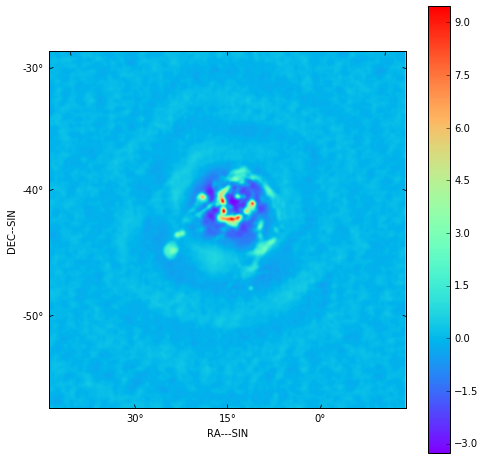

In [9]:
model = create_image_from_visibility(vt, cellsize=0.001, npixel=512)
#vt = weight_visibility(vt, model)
dirty, sumwt = invert_2d(vt, model)
psf, sumwt = invert_2d(vt, model, dopsf=True)
dirty.data = dirty.data/sumwt
psf.data = psf.data/sumwt

show_image(dirty)
print("Max, min in dirty image = %.6f, %.6f, sumwt = %f" % (dirty.data.max(), dirty.data.min(), sumwt))

print("Max, min in PSF         = %.6f, %.6f, sumwt = %f" % (psf.data.max(), psf.data.min(), sumwt))

export_image_to_fits(dirty, 'imaging_dirty.fits')
export_image_to_fits(psf, 'imaging_psf.fits')

Deconvolve using clean

deconvolve_cube: Processing pol 0, channel 0
msclean: Peak of PSF = 1.0 at (256, 256)
msclean: Peak of Dirty = 9.45805350326 at (281, 250)
msclean: Coupling matrix =
 [[ 1.          0.96479039  0.59761657  0.12586907]
 [ 0.96479039  0.93162728  0.58360935  0.12522794]
 [ 0.59761657  0.58360935  0.42181007  0.11607962]
 [ 0.12586907  0.12522794  0.11607962  0.06853152]]
msclean: Max abs in dirty Image = 9.458054
msclean: Start of minor cycle
msclean: This minor cycle will stop at 1000 iterations or peak < 0.0945805350326
msclean: Minor cycle 0, peak [ 8.83265953  8.76484485  7.9130232   5.07728808] at [269, 261, 3]
msclean: Minor cycle 100, peak [ 2.13833913  2.09278292  1.52820679  0.32427654] at [302, 271, 3]
msclean: Minor cycle 200, peak [ 0.63347315  0.63092218  0.57907988  0.14665265] at [284, 261, 3]
msclean: Minor cycle 300, peak [-0.14289703 -0.14343902 -0.14838509 -0.11768677] at [325, 205, 3]
msclean: Minor cycle 400, peak [-0.13342792 -0.13280243 -0.12418288 -0.09529656] at 

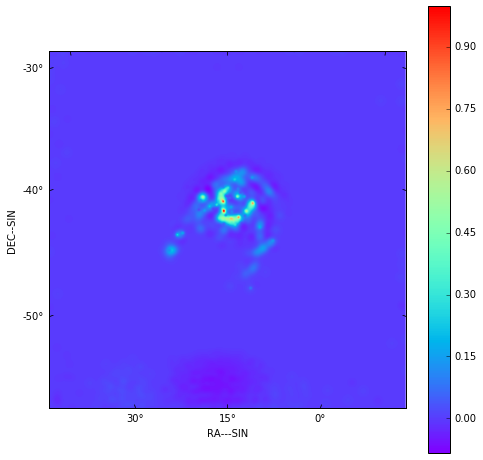

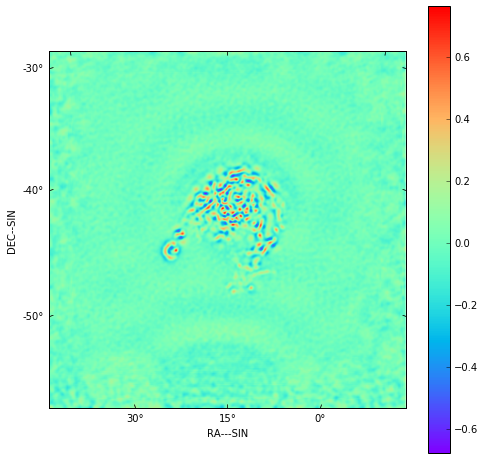

In [10]:
parameters={'niter':1000, 'threshold':0.001, 'fracthresh':0.01, 'scales':[0, 3, 10, 30]}
comp, residual = deconvolve_cube(dirty, psf, niter=1000, threshold=0.001, fracthresh=0.01, 
                                 scales=[0, 3, 10, 30])

# Show the results

fig=show_image(comp)
fig=show_image(residual)

Predict the visibility of the model

In [11]:
vtmodel = create_visibility(lowcore, times, frequency, weight=1.0, phasecentre=phasecentre)
vtmodel=predict_2d(vtmodel, comp)

create_visibility: Visibility has 123255 rows, total size 0.298 GB
predict_2d: predict using 2d transform


Now we will plot the original visibility and the residual visibility.

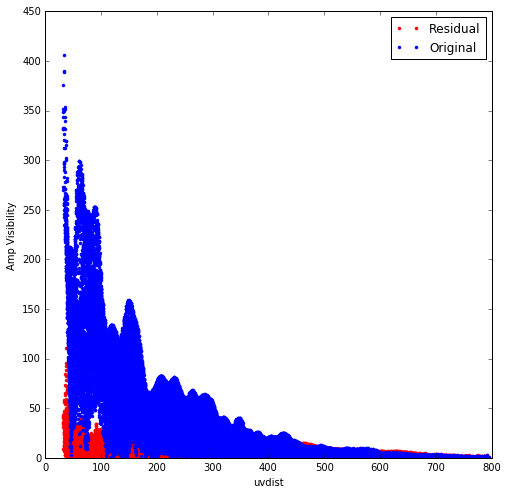

In [12]:
uvdist=numpy.sqrt(vt.data['uvw'][:,0]**2+vt.data['uvw'][:,1]**2)
plt.clf()
plt.plot(uvdist, numpy.abs(vt.data['vis'][:,0,0]-vtmodel.data['vis'][:,0,0]), '.', color='r', label='Residual')
plt.plot(uvdist, numpy.abs(vt.data['vis'][:,0,0]), '.', color='b', label='Original')

plt.xlabel('uvdist')
plt.ylabel('Amp Visibility')
plt.legend()
plt.show()